In [15]:
!ls /content/drive/MyDrive/data/image

ls: cannot access '/content/drive/MyDrive/data/image': No such file or directory


In [ ]:
#!7za -y x "/content/drive/MyDrive/My Projects/Expression Classification from Facial Images/data/image/origin.7z*"

In [ ]:
#!cp -r ./origin "/content/drive/MyDrive/My Projects/Expression Classification from Facial Images"

In [ ]:
label_path = r"/kaggle/input/expression-in-the-wild-expw-dataset/label.lst"
images_path=r"//kaggle/input/origin-expw/origin"

In [35]:
import pandas as pd

face_data = pd.read_csv(label_path, sep=" " , header= None)
face_data

,0,1,2,3,4,5,6,7
0,angry_actor_104.jpg,0,28,113,226,141,22.9362,0
1,angry_actor_109.jpg,0,31,157,345,219,50.3056,0
2,angry_actor_120.jpg,1,53,53,372,372,13.9434,2
3,angry_actor_13.jpg,0,77,51,362,388,85.8104,3
4,angry_actor_132.jpg,0,95,31,412,476,82.3948,0
...,...,...,...,...,...,...,...,...
91788,surprised_expression_546.jpg,0,70,70,351,351,37.7117,5
91789,surprised_expression_381.jpg,0,51,61,117,107,91.6307,5
91790,surprised_expression_395.jpg,0,27,95,258,190,96.2861,5
91791,ecstatic_asian_31.jpg,0,60,136,184,108,39.9223,3


In [ ]:
face_data.columns =['image_name', 'face_id_in_image', 'face_box_top', 'face_box_left' , 'face_box_right' , 'face_box_bottom' , 'face_box_cofidence' , 'expression_label']
face_data

In [32]:
face_data.shape

(91793, 8)

In [33]:
face_cofidence = face_data[face_data.face_box_cofidence > 55]

In [34]:
face_cofidence.shape

(39599, 8)

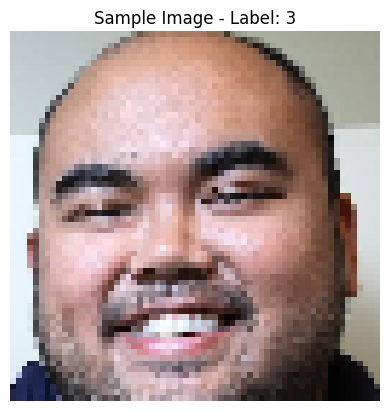

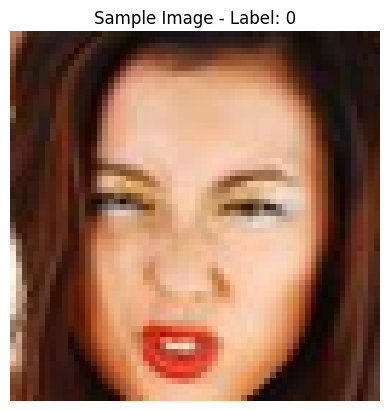

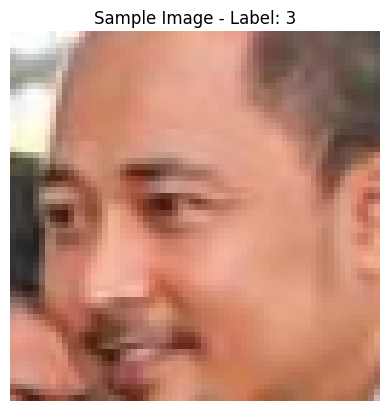

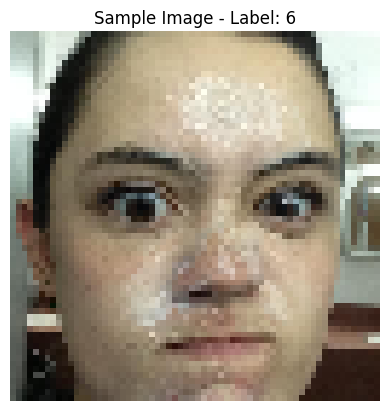

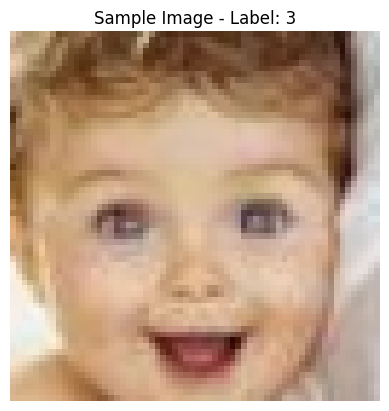

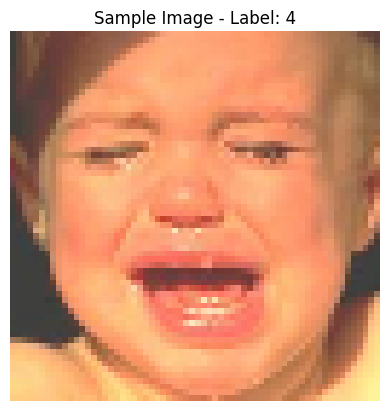

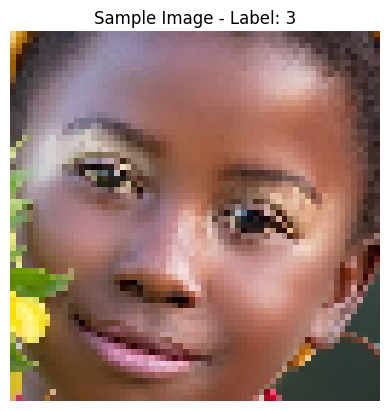

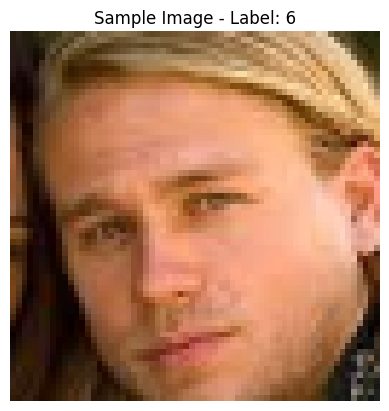

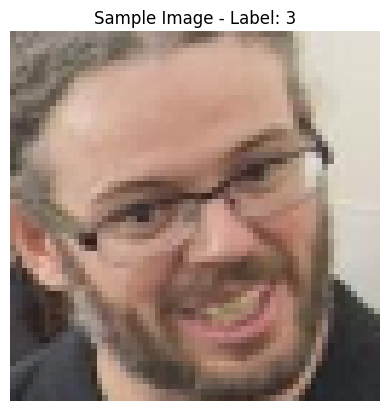

In [ ]:
from numpy.core.fromnumeric import resize
import cv2
import matplotlib.pyplot as plt
import os


stored_image = []
stored_label = []

for i, row in face_cofidence.sample(20000).iterrows():
    image_name = row["image_name"]
    left = row["face_box_left"]
    right = row["face_box_right"]
    top = row["face_box_top"]
    bottom = row["face_box_bottom"]
    label = row["expression_label"]
    img_path = os.path.join(images_path, image_name)
    read_image = cv2.imread(img_path)

    if read_image is not None:
         crop_image = read_image[top:bottom , left:right]
    else:
        continue

    if crop_image  is not None:
     crop_resize = cv2.resize(crop_image  , ( 64,64))

    else:
      continue

    stored_image.append(crop_resize)
    stored_label.append(label)

  # Display sample images at intervals
    if i % 1000 == 0:  # Adjust interval as needed
        plt.imshow(cv2.cvtColor(crop_resize, cv2.COLOR_BGR2RGB))
        plt.title(f'Sample Image - Label: {label}')
        plt.axis('off')
        plt.show()

In [ ]:
import numpy as np

X = np.array(stored_image)
Y = np.array(stored_label)

In [ ]:
x = X / 255.0

In [ ]:
X_shaped = x.reshape((-1,64*64*3))
X_shaped.shape

In [ ]:
import pandas as pd
pd.Series(Y).value_counts()

In [ ]:
# Check the shapes of X_shaped and Y
print("Shape of X_shaped:", X_shaped.shape)
print("Shape of Y:", Y.shape)

# Ensure that X_shaped and Y have the same number of samples
if X_shaped.shape[0] != Y.shape[0]:
    # Adjust X_shaped to match the number of samples in Y
    min_samples = min(X_shaped.shape[0], Y.shape[0])
    X_shaped = X_shaped[:min_samples]
    Y = Y[:min_samples]

# Recheck the shapes to confirm they match
print("Adjusted Shape of X_shaped:", X_shaped.shape)
print("Adjusted Shape of Y:", Y.shape)

# Apply SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_smote, Y_smote = smote.fit_resample(X_shaped, Y)
print("Shape after SMOTE - X_smote:", X_smote.shape)
print("Shape after SMOTE - Y_smote:", Y_smote.shape)


In [ ]:
pd.Series(Y_smote).value_counts()

In [ ]:
x = X_smote.reshape(-1,64,64,3)

In [ ]:
Y = Y_smote

In [ ]:
len(x)


In [ ]:
len(X)

In [ ]:
import numpy as np

from keras.utils import to_categorical
y = to_categorical(Y)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_temp, Y_train, Y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.2, random_state=42)


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


img_datagen = ImageDataGenerator(

    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


img_datagen.fit(X_train)

## ***MODEL***

In [36]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()

# First convolutional block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second convolutional block
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third convolutional block
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fourth convolutional block
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fifth convolutional block (newly added)
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))  # Added 'same' padding
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Fully connected layers
model.add(Flatten())
model.add(Dense(1024, activation='relu',kernel_regularizer=l2(0.001)))  # Larger dense layer
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer
num_classes = 7
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
# Summary of the model architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,194,375 (8.37 MB)

 Trainable params: 2,193,415 (8.37 MB)

 Non-trainable params: 960 (3.75 KB)

In [38]:
# Train the model
history = model.fit(
    img_datagen.flow(X_train, Y_train, batch_size=32),
    epochs=50,
    validation_data=(X_val, Y_val),
    steps_per_epoch=len(X_train) // 32,
    validation_steps=len(X_val) // 32
)

Epoch 1/50
1484/1484 ━━━━━━━━━━━━━━━━━━━━ 99s 59ms/step - accuracy: 0.1927 - loss: 2.2431 - val_accuracy: 0.2683 - val_loss: 1.8567
Epoch 2/50
1484/1484 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.1562 - loss: 1.9566 - val_accuracy: 0.2595 - val_loss: 1.8828
Epoch 3/50
1484/1484 ━━━━━━━━━━━━━━━━━━━━ 77s 52ms/step - accuracy: 0.2722 - loss: 1.8120 - val_accuracy: 0.3618 - val_loss: 1.6422
Epoch 4/50
1484/1484 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.2500 - loss: 1.8823 - val_accuracy: 0.3638 - val_loss: 1.6383
Epoch 5/50
1484/1484 ━━━━━━━━━━━━━━━━━━━━ 77s 51ms/step - accuracy: 0.3121 - loss: 1.7378 - val_accuracy: 0.3658 - val_loss: 1.5885
Epoch 6/50
1484/1484 ━━━━━━━━━━━━━━━━━━━━ 1s 531us/step - accuracy: 0.4688 - loss: 1.5290 - val_accuracy: 0.3693 - val_loss: 1.5793
Epoch 7/50
1484/1484 ━━━━━━━━━━━━━━━━━━━━ 76s 51ms/step - accuracy: 0.3471 - loss: 1.6665 - val_accuracy: 0.4264 - val_loss: 1.4772
Epoch 8/50
1484/1484 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.5625 -

In [35]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6034 - loss: 1.0337
Test Loss: 1.0455
Test Accuracy: 0.6020


319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


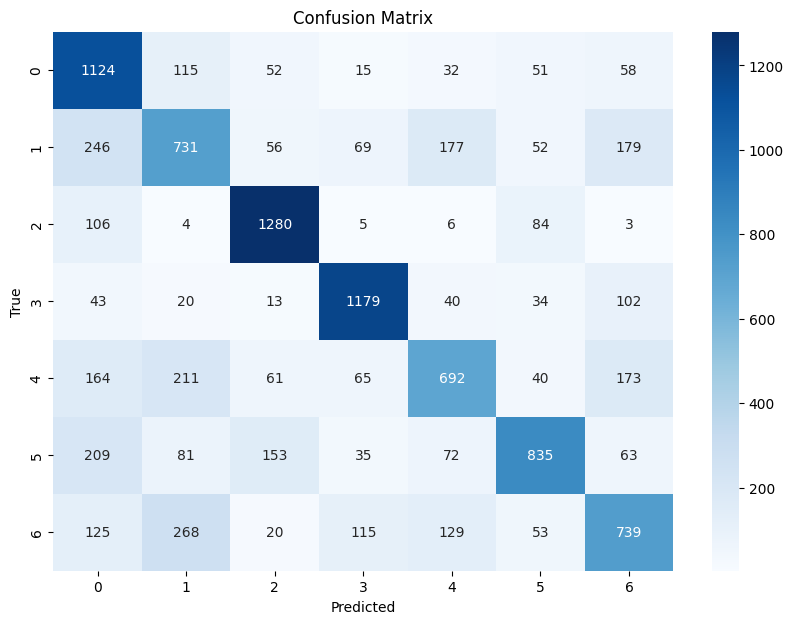

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test data
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [26]:
# Classification Report
print("Classification Report:")
print(classification_report(Y_true, Y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.78      0.65      1447
           1       0.51      0.48      0.50      1510
           2       0.78      0.86      0.82      1488
           3       0.80      0.82      0.81      1431
           4       0.60      0.49      0.54      1406
           5       0.73      0.58      0.64      1448
           6       0.56      0.51      0.53      1449

    accuracy                           0.65     10179
   macro avg       0.65      0.65      0.64     10179
weighted avg       0.65      0.65      0.64     10179



In [27]:
# F1 Score (macro and weighted)
f1 = f1_score(Y_true, Y_pred_classes, average='weighted')
print(f"F1 Score (Weighted): {f1:.4f}")

F1 Score (Weighted): 0.6420


In [28]:
# Accuracy Score
accuracy = accuracy_score(Y_true, Y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.6464


In [29]:
# Training and validation accuracy and loss
train_acc = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

Train Accuracy: 0.5000
Train Loss: 1.2349
Validation Accuracy: 0.6510
Validation Loss: 0.9275


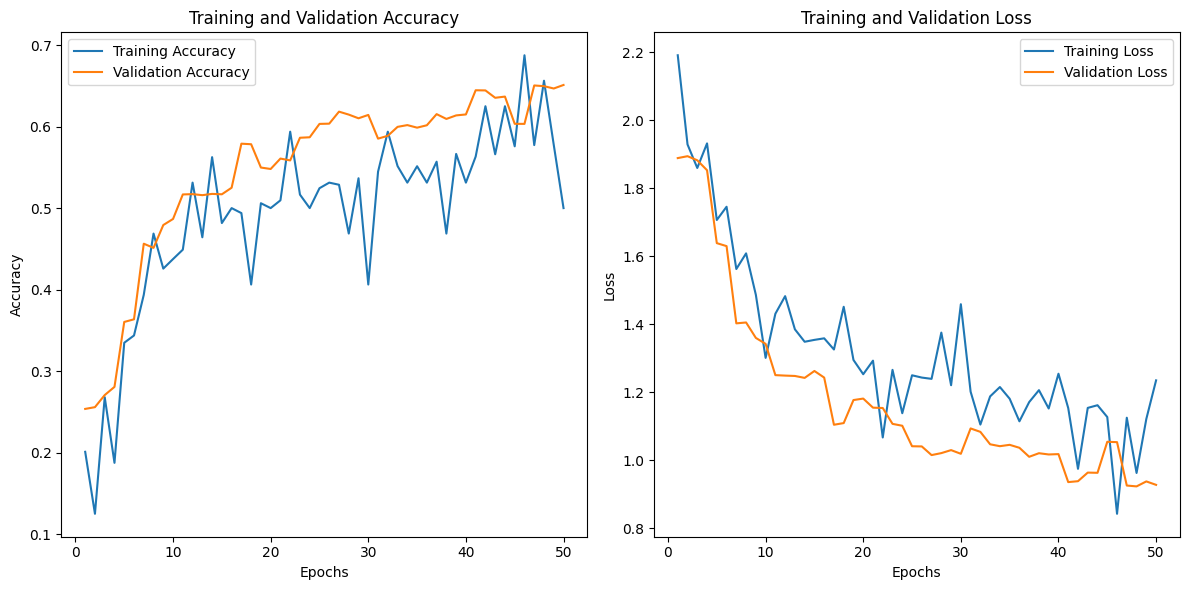

In [30]:
import matplotlib.pyplot as plt

# Retrieve metrics from the history object
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Number of epochs
epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


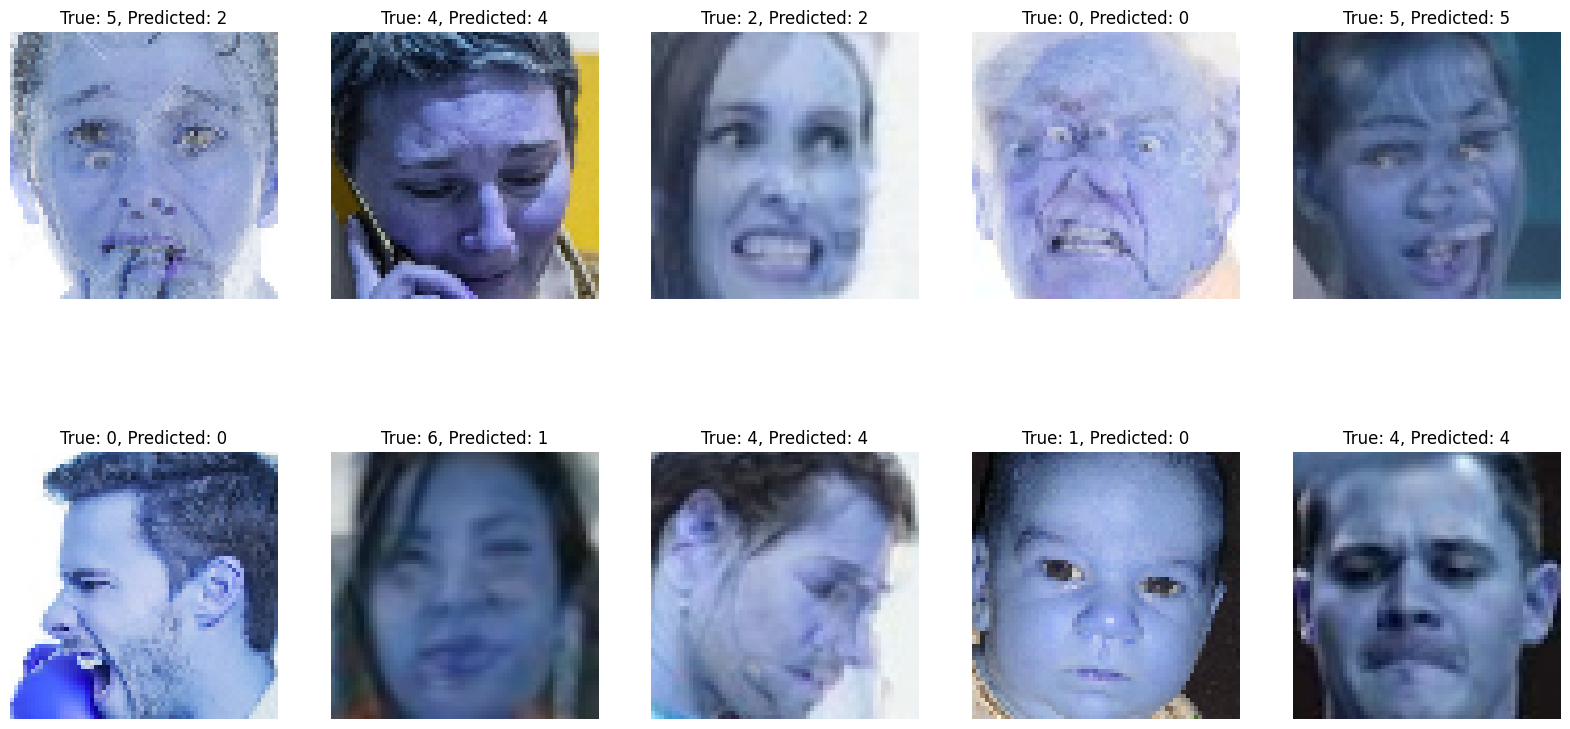

In [31]:
def show_top_predictions(images, true_labels, predicted_labels, top_n=10):
    plt.figure(figsize=(20, 10))
    for i in range(top_n):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i])
        plt.title(f"True: {true_labels[i]}, Predicted: {predicted_labels[i]}")
        plt.axis('off')
    plt.show()

# Show top 10 predictions
show_top_predictions(X_test[:10], Y_true[:10], Y_pred_classes[:10])
